# Inductive bias of neural networks

Neural networks have an inductive bias for learning smooth functions. For a class of learning problems like probability density estimation, I'd argue that it is the wrong bias.

For example, in case of a binary classification problem trained on 1-hot targets using softmax, outputs should represent probability of each class. For inputs that fall outside the training set, the network should produce close to 0 for both outputs. This is rarely the case due to the way neural networks learn smooth function.

In this notebook, I explore the differences between what a neural network classifier learns vs what it should "ideally" learn.


Experiment 1
x tensor([[0.5000]])
y tensor([[1.]])
Loss:  0.0004523028910625726


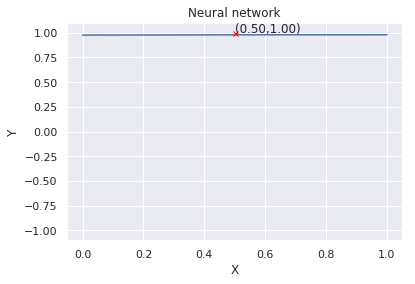

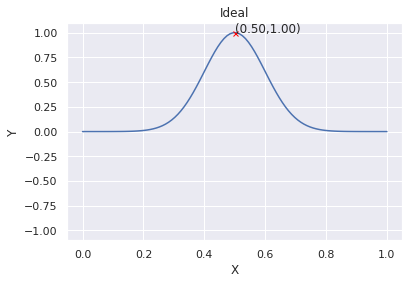

Experiment 2
x tensor([[0.3000],
        [0.7000]])
y tensor([[ 1.],
        [-1.]])
Loss:  0.0008798195049166679


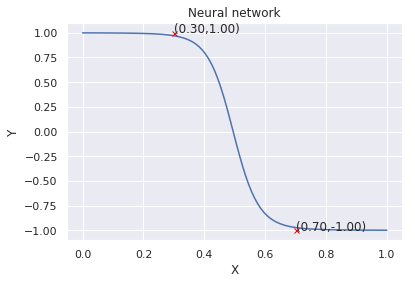

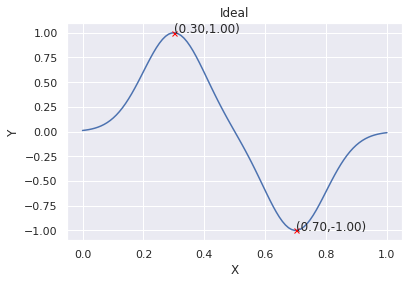

Experiment 3
x tensor([[0.3000],
        [0.7000],
        [0.6500]])
y tensor([[ 1.],
        [ 1.],
        [-1.]])
Loss:  0.7391262054443359


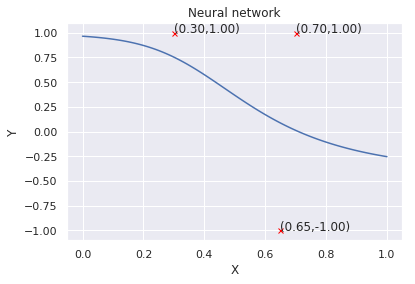

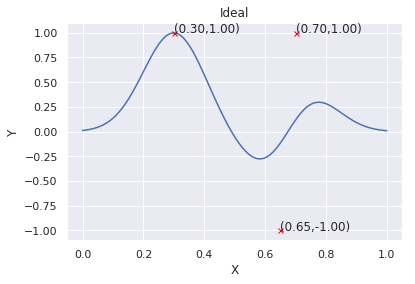

In [117]:
import torch
import torch.nn.functional as F
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy import stats
from scipy.stats import norm

class NN(torch.nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(NN, self).__init__()
    self.linear1 = torch.nn.Linear(input_size, hidden_size)
    self.linear2 = torch.nn.Linear(hidden_size, hidden_size)
    self.linear3 = torch.nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = torch.tanh(self.linear1(x))
    x = torch.tanh(self.linear2(x))
    x = torch.tanh(self.linear3(x))
    return x

def train_model(x, y):
  # Construct our model by instantiating the class defined above.
  model = NN(input_size=x.shape[-1], hidden_size=x.shape[-1]*4, output_size=y.shape[-1])

  loss_fn = torch.nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
  for t in range(5000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)
    #print("y_pred", y_pred)

    # Compute and print loss
    loss = loss_fn(y_pred, y)
    #print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #if t % 100 == 0:
    #  print("Loss: ", loss.item())

  print("Loss: ", loss.item())
  return model


def plot(x, xlabel, y, ylabel, title, xtrain, ytrain):
  x = x.squeeze().numpy()
  y = y.squeeze().numpy()
  plt.plot(x, y)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.ylim(-1.1,1.1)
  
  xtrain = xtrain.numpy()
  ytrain = ytrain.numpy()
    
  plt.plot(xtrain, ytrain, marker='x', markersize=5, color="red", linestyle = 'None')
  for i,j in zip(xtrain,ytrain):
    plt.annotate(f"({i[0]:.2f},{j[0]:.2f})",xy=(i,j))
  
  plt.show()
  
def get_ideal_function(x, y, test_x):
  test_x = test_x.squeeze()
  output = torch.zeros(test_x.shape).float()
  for i in range(x.shape[0]):
    x_i = x[i]
    y_i = y[i]
    var = 0.1
    gaussian = torch.tensor(norm.pdf(test_x.numpy(), x_i, var)).float()
    gaussian = y_i * gaussian / gaussian.max()
    output += gaussian
  return output

def run_experiment(title, x, y):
  print(title)
  print("============")
  input_size, hidden_size, output_size = x.shape[-1], 4, y.shape[-1]
  
  print("x", x)
  print("y", y)
  model = train_model(x, y)

  test_x = torch.linspace(0, 1, 100).unsqueeze(dim=1)
  plot(x=test_x, xlabel="X", y=model(test_x).detach(), ylabel="Y", title="Neural network", xtrain=x, ytrain=y)
  plot(x=test_x, xlabel="X", y=get_ideal_function(x, y, test_x), ylabel="Y", title="Ideal", xtrain=x, ytrain=y)
  
x = torch.tensor([[0.5]])
y = torch.tensor([[1.0]])
run_experiment("Experiment 1", x, y)


x = torch.tensor([[0.3], [0.7]])
y = torch.tensor([[1.0], [-1.0]])
run_experiment("Experiment 2", x, y)

x = torch.tensor([[0.3], [0.7], [0.65]])
y = torch.tensor([[1.0], [1.0], [-1.0]])
run_experiment("Experiment 3", x, y)

# Compute CDF

Given a set a x values, with x just a float for now -
- Find the bucket the values belong to
- Sum up how many values in each bucket and put that together in a 1D tensor
- Use the counts tensor to build a CDF

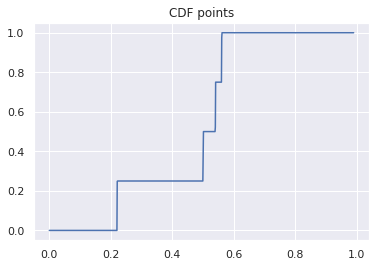

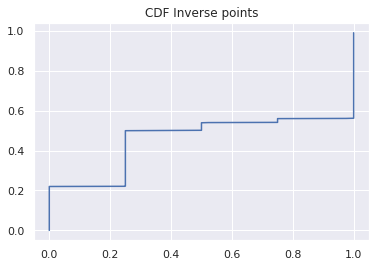

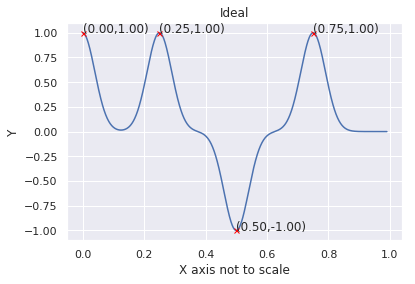

In [122]:
import math

resolution_10_power = 3
resolution = 10 ** resolution_10_power
resolution

sample_counts = torch.zeros((resolution,))

x = torch.tensor([0.5, 0.22, 0.56, 0.54])
y = torch.tensor([1, 1, 1, -1])
x_bucket = (x * resolution).long()
indices, counts = x_bucket.unique(return_counts=True)
for i in range(indices.shape[-1]):
  sample_counts[indices[i]] += counts[i]
  
cumsum = sample_counts.cumsum(0)
cdf_table = (cumsum * resolution / cumsum[-1]).double()

def cdf(x_query, cdf_table, resolution):
  #print("x_query", x_query)
  query_index = int(x_query * resolution)
  if query_index == 0 or cdf_table[query_index] == cdf_table[query_index - 1]:
    result = cdf_table[query_index]
  else:
    #print("query_index", query_index)
    a = cdf_table[query_index - 1]
    #print("a", a)
    b = cdf_table[query_index]
    #print("b", b)
    fraction = x_query * resolution - query_index
    #print("fraction", fraction)
    result = a + fraction * (b - a)
    #print("result", result)

  return result / resolution

test_x = torch.linspace(0, 0.99, resolution).double()
test_x_tilda = torch.tensor([cdf(x, cdf_table, resolution) for x in test_x])
test_x_tilda

plt.plot(test_x.numpy(), test_x_tilda.numpy())
plt.title("CDF points")
plt.show()
points = torch.cat((test_x.unsqueeze(dim=1), test_x_tilda.unsqueeze(dim=1)), 1)

def rotate(points, degrees):
  radians = degrees * math.pi / 180.0
  rotation = torch.tensor([[math.cos(radians), -math.sin(radians)],[math.sin(radians), math.cos(radians)]]).double()
  return points @ rotation


points_inverse = rotate(points, 45) # rotate 45deg
points_inverse[:, 1] *= -1 # reflect around X axis
points_inverse = rotate(points_inverse, -45) # rotate back

plt.plot(points_inverse[:, 0].numpy(), points_inverse[:, 1].numpy())
plt.title("CDF Inverse points")
plt.show()

cdf_inverse_table = points_inverse[:, 0] * resolution

def get_ideal_function(x, y, test_x):
  test_x = test_x.squeeze()
  output = torch.zeros(test_x.shape).float()
  for i in range(x.shape[0]):
    x_i = x[i]
    y_i = y[i]
    var = 0.04
    
    x_i_tilda = cdf(x_i.numpy(), cdf_inverse_table, resolution)
    gaussian = torch.tensor(norm.pdf(test_x.numpy(), x_i_tilda, var)).float()
    gaussian = y_i * gaussian / gaussian.max()
    output += gaussian
  return output

plot(x=test_x, xlabel="X axis not to scale", y=get_ideal_function(x, y, test_x), ylabel="Y", title="Ideal", xtrain=torch.tensor([cdf(x_i.numpy(), cdf_inverse_table, resolution) for x_i in x]).unsqueeze(1), ytrain=y.unsqueeze(1))


In [111]:
torch.tensor([[0.5]]).numpy().shape

(1, 1)